## **1. Import libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn
import torch.optim as optim
import nltk
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lurke\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **2. Read dataset**

In [2]:
dataset_path = 'Twitter_Data.csv'
df = pd.read_csv(
    dataset_path
)
df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [4]:
df.describe()

,category
count,162973.000000
mean,0.225436
std,0.781279
min,-1.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## **3. Drop missing value**

In [5]:
null_rows = df.isnull().any(axis=1)
df[null_rows]

,clean_text,category
148,NaN,0.0
130448,the foundation stone northeast gas grid inaugu...,NaN
155642,dear terrorists you can run but you cant hide ...,NaN
155698,offense the best defence with mission shakti m...,NaN
155770,have always heard politicians backing out thei...,NaN
158693,modi government plans felicitate the faceless ...,NaN
158694,NaN,-1.0
159442,chidambaram gives praises modinomics,NaN
159443,NaN,0.0
160559,the reason why modi contested from seats 2014 ...,NaN


In [6]:
df = df.dropna()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162969 non-null  object 
 1   category    162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB


## **4. Preprocessing data**



In [8]:
def text_normalize(text):
    # Lowercasing
    text = text.lower()
    # Retweet old acronym "RT" removal
    text = re.sub(r'~RT[\s]+', '', text)

    # Hyperlinks removal
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

    # Punctuation removal
    text = re.sub(r'[^\w\s]', '', text)

    # Hashtag removal
    text = re.sub(r'#', '', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))

    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)

    # Steaming
    stemmer = SnowballStemmer('english')
    words = text.split()
    words = [stemmer.stem(word) for word in words]
    text = ' '.join(words)

    return text

In [9]:
df['clean_text'] = df['clean_text'].apply(
    lambda x: text_normalize(x)
)

C:\Users\lurke\AppData\Local\Temp\ipykernel_20840\141919810.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['clean_text'].apply(


In [10]:
df

,clean_text,category
0,modi promis minimum govern maximum govern expe...,-1.0
1,talk nonsens continu drama vote modi,0.0
2,say vote modi welcom bjp told rahul main campa...,1.0
3,ask support prefix chowkidar name modi great s...,1.0
4,answer among power world leader today trump pu...,1.0
...,...,...
162975,456 crore paid neerav modi recov congress lead...,-1.0
162976,dear rss terrorist payal gawar modi kill 1000 ...,-1.0
162977,cover interact forum left,0.0
162978,big project came india modi dream project happ...,0.0


## **5. One-hot encoding label**

In [11]:
vectorizer = TfidfVectorizer(max_features =2000)
X =vectorizer.fit_transform(df['clean_text']).toarray()

In [12]:
n_classes = df['category'].nunique()
n_samples = df['category'].size

y = df['category'].to_numpy() + 1
y = y.astype(np.uint8)

y_encoded = np.zeros((n_samples, n_classes))

y_encoded[np.arange(n_samples), y] = 1

y_encoded

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

## **6. Create train, val, test set**

In [13]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y_encoded, dtype=torch.float32)

In [14]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [15]:
print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of val samples: {X_val.shape[0]}')
print(f'Number of test samples: {X_test.shape[0]}')

Number of training samples: 114078
Number of val samples: 32594
Number of test samples: 16297


## **7. Define Softmax Regression model**

In [17]:
class SoftmaxRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SoftmaxRegression, self).__init__()
        self.linear = nn.Linear(
            input_dim,
            output_dim,
            bias=True
        )

    def forward(self, x):
        return self.linear(x)

In [23]:
def compute_accuracy(y_hat, y):
    _, y_hat = torch.max(y_hat, dim=1)
    _, y_true = torch.max(y, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = (correct / len(y_true))
    return accuracy

## **8. Training**

In [21]:
lr = 0.1
epochs = 500
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

model = SoftmaxRegression(
    input_dim, output_dim
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(), lr=lr
)

In [ ]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    model.train()

    optimizer.zero_grad()

    y_hat = model(X_train)

    train_loss = criterion(y_hat, y_train)
    train_losses.append(train_loss)

    train_acc = compute_accuracy(y_hat, y_train)
    train_accs.append(train_acc)

    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        y_val_hat = model(X_val)

        val_loss = criterion(y_val_hat, y_val)
        val_losses.append(val_loss)

        val_acc = compute_accuracy(y_val_hat, y_val)
        val_accs.append(val_acc)
    
        
    print (f'\nEPOCH { epoch + 1}:\tTraining loss : {train_loss :.3f}\tValidation loss : {val_loss :.3f}')



EPOCH 1:	Training loss : 1.091	Validation loss : 1.089

EPOCH 2:	Training loss : 1.089	Validation loss : 1.087

EPOCH 3:	Training loss : 1.087	Validation loss : 1.085

EPOCH 4:	Training loss : 1.085	Validation loss : 1.083

EPOCH 5:	Training loss : 1.084	Validation loss : 1.082

EPOCH 6:	Training loss : 1.082	Validation loss : 1.080

EPOCH 7:	Training loss : 1.081	Validation loss : 1.079

EPOCH 8:	Training loss : 1.079	Validation loss : 1.077

EPOCH 9:	Training loss : 1.078	Validation loss : 1.076

EPOCH 10:	Training loss : 1.077	Validation loss : 1.075

EPOCH 11:	Training loss : 1.076	Validation loss : 1.074

EPOCH 12:	Training loss : 1.075	Validation loss : 1.073

EPOCH 13:	Training loss : 1.074	Validation loss : 1.072

EPOCH 14:	Training loss : 1.073	Validation loss : 1.071

EPOCH 15:	Training loss : 1.072	Validation loss : 1.070

EPOCH 16:	Training loss : 1.071	Validation loss : 1.069

EPOCH 17:	Training loss : 1.070	Validation loss : 1.068

EPOCH 18:	Training loss : 1.069	Validat

In [30]:
train_losses

[tensor(1.0911, grad_fn=<DivBackward1>),
 tensor(1.0891, grad_fn=<DivBackward1>),
 tensor(1.0872, grad_fn=<DivBackward1>),
 tensor(1.0854, grad_fn=<DivBackward1>),
 tensor(1.0837, grad_fn=<DivBackward1>),
 tensor(1.0821, grad_fn=<DivBackward1>),
 tensor(1.0807, grad_fn=<DivBackward1>),
 tensor(1.0793, grad_fn=<DivBackward1>),
 tensor(1.0780, grad_fn=<DivBackward1>),
 tensor(1.0768, grad_fn=<DivBackward1>),
 tensor(1.0757, grad_fn=<DivBackward1>),
 tensor(1.0746, grad_fn=<DivBackward1>),
 tensor(1.0736, grad_fn=<DivBackward1>),
 tensor(1.0727, grad_fn=<DivBackward1>),
 tensor(1.0718, grad_fn=<DivBackward1>),
 tensor(1.0710, grad_fn=<DivBackward1>),
 tensor(1.0702, grad_fn=<DivBackward1>),
 tensor(1.0695, grad_fn=<DivBackward1>),
 tensor(1.0688, grad_fn=<DivBackward1>),
 tensor(1.0682, grad_fn=<DivBackward1>),
 tensor(1.0676, grad_fn=<DivBackward1>),
 tensor(1.0670, grad_fn=<DivBackward1>),
 tensor(1.0665, grad_fn=<DivBackward1>),
 tensor(1.0660, grad_fn=<DivBackward1>),
 tensor(1.0655, 

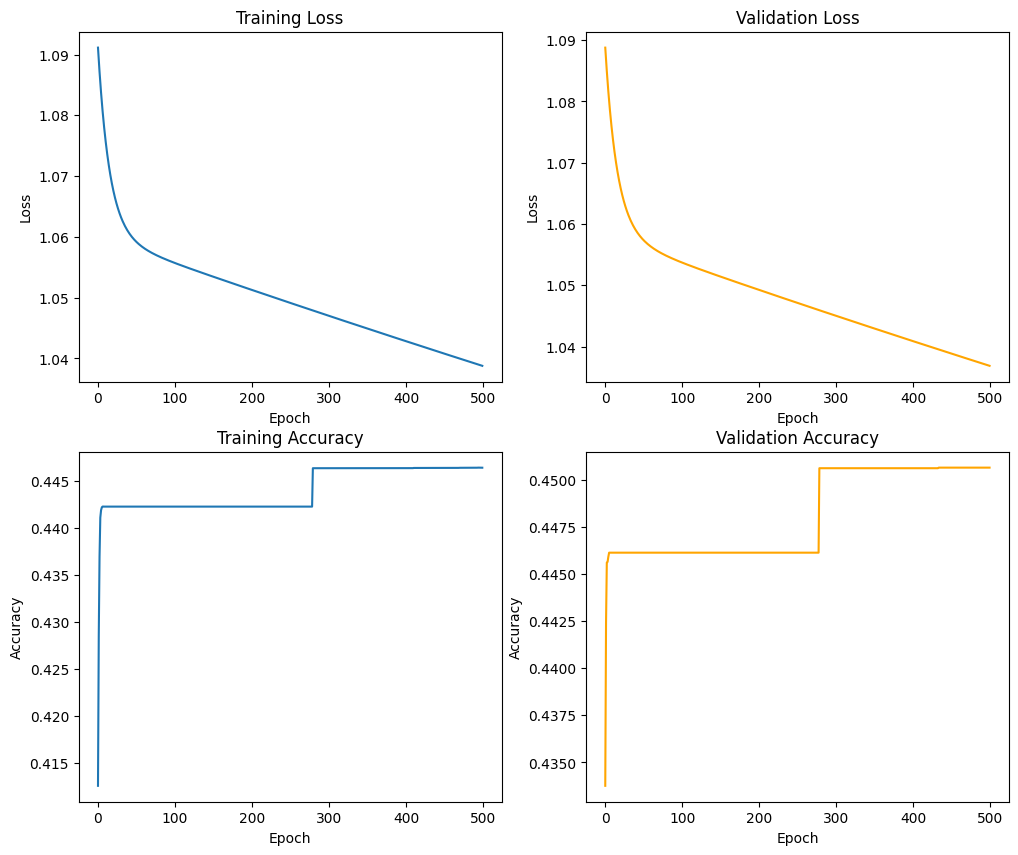

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Convert values to numpy, handling both tensors and floats
ax[0, 0].plot([loss.detach().numpy() if hasattr(loss, 'detach') else loss for loss in train_losses])
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot([loss.detach().numpy() if hasattr(loss, 'detach') else loss for loss in val_losses], color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot([acc.detach().numpy() if hasattr(acc, 'detach') else acc for acc in train_accs])
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot([acc.detach().numpy() if hasattr(acc, 'detach') else acc for acc in val_accs], color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()


## **9. Evaluation**

In [33]:
# Val set
model.eval()
with torch.no_grad():
    y_hat = model(X_val)
    val_set_acc = compute_accuracy(y_hat, y_val)
    print('Evaluation on validation set:')
    print(f'Accuracy: {val_set_acc}')

Evaluation on validation set:
Accuracy: 0.4506350862121863


In [34]:
# Test set
model.eval()
with torch.no_grad():
    y_hat = model(X_test)
    test_set_acc = compute_accuracy(y_hat, y_test)
    print('Evaluation on test set:')
    print(f'Accuracy: {test_set_acc}')

Evaluation on test set:
Accuracy: 0.4491010615450696
